# **PDF support in Claude 3.5 Sonnet API New Feature:**

Anthropic introduces PDF support in Claude 3.5 Sonnet API, enabling seamless integration of PDF documents into AI workflows.


Claude 3.5 Sonnet now allows users to upload PDFs directly into the model using the API, bypassing the need for manual text extraction or conversion. This feature makes it easier to analyze and respond to queries based on detailed documents without extra steps.


👉 **Key Features:**

- **Direct PDF Uploads:** Users can now upload PDFs directly using the API, allowing Claude to process and analyze the content without manual text extraction.
- **Enhanced Data Extraction:** Claude can extract text, tables, and images from PDFs, facilitating comprehensive data analysis.

This feature expands the ability to get insights and allows for more comprehensive answers based on data from different sources within the document.



👉 **Use Cases:**

This new feature can be used for:

- **Document Summarization** to quickly generate concise summaries of lengthy reports or articles
- **Data Analysis** to extract and analyze data from financial statements, research papers, and other structured documents.
- **Content Generation** to utilize extracted information to create new content, such as reports or presentations.


👉 **How PDF Support Operates**:

When you submit a request with a PDF file, here’s how the process works:

1️⃣ **Extracting Document Contents**

   - The system first processes the document by converting each page into an image.

   - Text is then extracted from each page and paired with its respective image, creating a comprehensive data set for each page.


2️⃣ **Combined Analysis of Text and Images**

   - Claude analyzes both the extracted text and the images to understand the document’s content thoroughly.

   - This approach enables users to gain insights into visual elements like charts, diagrams, and other non-text components within the PDF.

3️⃣ **Seamless Integration with Other Claude Features**

   - PDF support works well with : Prompt caching, Batch processing, Tool integration.

This comprehensive support enhances the ability to analyze and interact with PDF files, making it a powerful tool for extracting both textual and visual information.


👉 **Constraints**:

- Maximum request size	32MB
- Maximum pages	100

You can also use token counting to determine the number of tokens in a message containing PDFs.

In "Counting Tokens" paragraph, I'll show you how to use count for tokens endpoint.





👉 **BlackRock Q4 2024 Outlooks report:**
I've conducted a test using BlackRock report for Q4 2024 outlooks. This report outlines BlackRock's key investment strategies across three main areas: equities, fixed income , and alternative assets. The document provides detailed analysis and recommendations for positioning portfolios amid market volatility, falling interest rates, and the upcoming US presidential election, while emphasizing the importance of maintaining a selective approach across asset classes.


This report contains a range of text, figures, and charts. The aim was to test the new PDF support feature.

[Hanane Dupouy](https://www.linkedin.com/in/hanane-d-algo-trader)

# Install libs

In [ ]:
!pip install anthropic -q

In [ ]:
import anthropic
import base64

In [ ]:
from google.colab import userdata
CLAUDE_API_KEY = userdata.get('CLAUDE_API_KEY')

# PDF loading

In [ ]:
def upload_pdf(path_to_pdf):
  with open(path_to_pdf, "rb") as pdf_file:
    binary_data = pdf_file.read()
    base_64_encoded_data = base64.b64encode(binary_data)
    base64_string = base_64_encoded_data.decode('utf-8')
  return base64_string

The BlackRock PDF originally has 19 pages, but I’ve excluded the last 6 pages as they mostly contain risk warnings for various countries where BlackRock operates. These sections don’t add value to the Q4 2024 outlook and would increase token count, raising costs.

In [ ]:
# BlackRock: Key Themes and Outlook for Q4 2024
# BlackRock pdf source: https://www.blackrock.com/institutions/en-zz/literature/whitepaper/investment-directions-q4-24-np.pdf

path_to_pdf = local_path + 'BlackRock_investment-directions-q4-24-np-1-13.pdf'
pdf_data = upload_pdf(path_to_pdf)

Before uploading the PDF to Anthropic and testing this new feature, let’s first count the number of tokens, understand the rate limits, and compare them to the feature's constraints.

# Counting Tokens

You are not charged when asking for tokens counting.

In [ ]:
client = anthropic.Anthropic(api_key = CLAUDE_API_KEY)

# path_to_pdf = local_path + 'BlackRock_investment-directions-q4-24-np-1-13.pdf'
# pdf_data = upload_pdf(path_to_pdf)

response = client.beta.messages.count_tokens(
    betas=["token-counting-2024-11-01", "pdfs-2024-09-25"],
    model="claude-3-5-sonnet-20241022",
    messages=[{
        "role": "user",
        "content": [
            {"type": "document", "source": { "type": "base64", "media_type": "application/pdf", "data": pdf_data}},
            {"type": "text", "text": "Please summarize this document."}
        ]
    }]
)

print(response.json())

{"input_tokens":31042}


Here are the number of tokens in the original pdf:

In [ ]:
# client = anthropic.Anthropic(api_key = CLAUDE_API_KEY)

import httpx

pdf_url = "https://www.blackrock.com/institutions/en-zz/literature/whitepaper/investment-directions-q4-24-np.pdf"
pdf_data = base64.standard_b64encode(httpx.get(pdf_url).content).decode("utf-8")

response = client.beta.messages.count_tokens(
    betas=["token-counting-2024-11-01", "pdfs-2024-09-25"],
    model="claude-3-5-sonnet-20241022",
    messages=[{
        "role": "user",
        "content": [
            {"type": "document", "source": { "type": "base64", "media_type": "application/pdf", "data": pdf_data}},
            {"type": "text", "text": "Please summarize this document."}
        ]
    }]
)

print(response.json())
#I have a rate limit of 40 000 tokens per minute. I decided to remove the last 6 pages to reduce this number.

{"input_tokens":49563}


**Tokens Counting - Takeaways:**


As I have excluded the last 6 pages, I reduced the number of tokens from 49K to 31K.

The rate limit for the latest sonnet model is 40 000 tokens per minute.

Also we need to not exceed 100 pages to use this new feature, where each page should be between 1500 to 3000. With our 31K tokens we are so far from this limit.

# Anthropic completion: Specify the access to the new beta-feature : "PDF"

Either you specify it in the header or inside the message creation endpoint:
"pdfs-2024-09-25"

I've also added the prompt caching feature to reduce costs (I'll explain it in another notebook)

In [ ]:
# ["pdfs-2024-09-25", "prompt-caching-2024-07-31"],

client = anthropic.Anthropic(api_key = CLAUDE_API_KEY)
# client = anthropic.Anthropic(default_headers={
#     "anthropic-beta": {"pdfs-2024-09-25","prompt-caching-2024-07-31"}
#   },
#   api_key = CLAUDE_API_KEY
# )

# For now, only claude-3-5-sonnet-20241022 supports PDFs
MODEL_NAME = "claude-3-5-sonnet-20241022"

def get_completion(messages, model=MODEL_NAME):
    completion = client.beta.messages.create(
        betas=["pdfs-2024-09-25", "prompt-caching-2024-07-31"],
        model=model,
        max_tokens=8192,
        messages=messages,
        temperature=0,
    )
    return completion

# Create the message with PDF data and start chatting:

## First query: Summarize the document

This simple query does not specify prompt caching parameter.
This is to simply test the PDF feature:

In [ ]:
messages = [
    {
        "role": 'user',
        "content": [
            {"type": "document", "source": {"type": "base64", "media_type": "application/pdf", "data": pdf_data}},
            {"type": "text", "text": "Summarise the document."}
        ]
    }
]

completion = get_completion(messages)

print(completion.content[0].text)

This document is BlackRock's Q4 2024 Investment Directions report for EMEA, outlining their investment strategy and market outlook. Here are the key points:

1. Overall Market View:
- Positive but cautious sentiment towards equities
- Focus on managing volatility ahead of US presidential election
- Emphasis on quality investments and broader earnings opportunities
- Positioning for global easing cycles as central banks begin rate cuts

2. Key Investment Areas:

Equities:
- Favoring quality stocks and broader market opportunities beyond US tech
- Seeing strong opportunities in Europe with selective, active approach
- Maintaining focus on AI beneficiaries but with broader sector exposure

Fixed Income:
- Recommending locking in income while rates remain elevated
- Preferring belly of US Treasury curve
- More comfortable extending duration in European bonds
- Favoring EUR credit over USD, with preference for quality

Alternative Investments:
- Increasing focus on liquid alternatives for p

## Set of queries: Equities related questions, AI questions and US Elections questions

In this method, I added the **cache_control** parameter to implement the **prompt** **caching** in the following interactions with Claude 3.5 Sonnet:

In [ ]:
def build_message (query, pdf_data):
  messages = [
      {
          "role": 'user',
          "content": [
              {"type": "document", "source": {"type": "base64", "media_type": "application/pdf", "data": pdf_data},"cache_control": {"type": "ephemeral"}},
              {"type": "text", "text": query}
          ]
      }
    ]
  return messages

Here are the different questions I'll be asking about various topics discussed in the report: Equities, AI and US Election.

In [ ]:
# Equities
queries_equities = ["What are BlackRock's recommendations for equity investments in Q4 2024?",
"How is the broadening of earnings impacting equity investments according to BlackRock?",
"Why does BlackRock suggest focusing on high-quality stocks in the current market?'"
]

# AI
queries_ai = [
"How does BlackRock view AI as a theme for investment?",
"What sectors does BlackRock believe could benefit from AI infrastructure growth?",
"What are BlackRock’s thoughts on the impact of AI capex on market valuations?"
]

# US ELECTION
queries_us_election = [
"How does BlackRock anticipate the US election may impact trade policies?",
"What potential market impacts does BlackRock see from the 2024 US presidential election?",
"How could UK equities serve as a hedge according to BlackRock’s election outlook?"]

### Equities Related Questions:

In [ ]:
for query in queries_equities:
  messages = build_message(query, pdf_data)
  print("--------QUERY---------")
  print(query)
  print()
  completion = get_completion(messages)
  print("--------ANSWER---------")
  print(completion.content[0].text)
  print()
  print("--------TOKENS COUNT---------")
  print(completion.usage)
  print()
  print("--------STOP REASON---------")
  print(completion.stop_reason)
  print()

--------QUERY---------
What are BlackRock's recommendations for equity investments in Q4 2024?

--------ANSWER---------
Based on the document, here are BlackRock's key equity investment recommendations for Q4 2024:

1. Quality and Breadth Focus:
- Look to take advantage of broadening earnings prospects while maintaining a quality tilt and selectivity amid volatility
- Maintain conviction in US equities but with a more granular, active approach
- Moving from narrow US tech focus to a wider set of opportunities

2. Regional Preferences:
- Continue to favor US equities
- See strong opportunities in Europe, particularly through selective active management
- Prefer granular, active approach for European exposure
- Like India within emerging markets for its low correlation to global equities

3. Sector Positioning:
- Continue to see tailwinds for AI beneficiaries
- Favor utilities and REITs which may benefit from lower rates
- Look favorably on European banks due to earnings potential despit

**Takeaways**:

The first thing that caught my attention was the variety of numbers Claude collected to answer queries 2 and 3. I fact-checked these numbers, and they are accurate.

Overall, the model’s answers are precise and are supported by well-retrieved figures, adding valuable context to the queries.


### AI Related Questions:

In [ ]:
from IPython.display import HTML

In [ ]:
for idx, query in enumerate(queries_ai):
  display(HTML(f"<p style='color:red;'>Query n° {idx}</p>"))
  messages = build_message(query, pdf_data)
  display(HTML(f"<p style='color:fuchsia;'>--------QUERY---------</p>"))
  display(HTML(f"<p style='color:fuchsia;'>{query}</p>"))
  print()
  completion = get_completion(messages)
  display(HTML(f"<p style='color:green;'>--------ANSWER---------</p>"))
  print(completion.content[0].text)
  print()
  display(HTML(f"<p style='color:blue;'>--------TOKENS COUNT---------</p>"))
  display(HTML(f"<p style='color:blue;'>{completion.usage}</p>"))
  print()
  print("--------STOP REASON---------")
  print(completion.stop_reason)
  print("\n\n")

Based on the document, BlackRock maintains a positive view on AI as an investment theme in Q4 2024, but suggests a more nuanced approach compared to earlier in the year. Here are the key points about their AI investment perspective:

1. Continued Conviction:
- They "continue to see tailwinds for AI beneficiaries"
- Maintain conviction in the AI theme, but suggest patience is needed as the build-out has "far to go"

2. Broadening Focus:
- Moving from a narrow US tech focus to "a wider set of opportunities"
- Looking beyond early AI winners to capture broader earnings growth
- Expanding to first-phase beneficiaries in sectors like:
  - Energy
  - Infrastructure 
  - Utilities (for powering AI infrastructure)

3. Infrastructure Emphasis:
- Highlight the significant power and infrastructure requirements for AI development
- Note that a data center using a 100k GPU cluster would require "a small power plant to run"
- See opportunities in public infrastructure and utilities sectors to suppor


--------STOP REASON---------
end_turn





According to the document, BlackRock identifies several sectors that could benefit from AI infrastructure growth:

1. Utilities - The document notes that utilities could benefit from AI's massive power requirements, as data centers using large GPU clusters for AI require significant power capacity. It mentions that "a data centre using a 100k GPU cluster – a target in sight for several large AI players – would require a small power plant to run."

2. Infrastructure - Public infrastructure is highlighted as being well-positioned to support the growing AI demand, with a strong tilt toward the utilities sector.

3. Sustainable Energy - The document indicates they "look to sustainable energy exposures" given the power demands of AI, against a backdrop of advancing technology, declining costs and supportive policy.

4. Technology - While maintaining conviction in tech's growth prospects, BlackRock suggests broadening exposure beyond just direct AI companies to include "first-phase beneficia


--------STOP REASON---------
end_turn





Based on the document, BlackRock has several key thoughts on AI capex and market valuations:

1. They believe patience is needed regarding AI capex, noting that "the build-out still has far to go" but sentiment shifts around AI capital expenditure could weigh on valuations.

2. They are fine-tuning their AI exposure approach by:
- Broadening beyond just direct AI technology companies
- Looking at "first-phase beneficiaries" in sectors like:
  - Energy
  - Infrastructure 
  - Utilities (which will be needed to power and build out AI infrastructure)

3. They note that markets may be "underestimating the scale of capex and AI power needs" - particularly around power capacity requirements for large AI models and data centers.

4. While maintaining conviction in tech overall, they acknowledge investor questions about whether "the price for growth may be too high" but maintain belief in tech's growth prospects.

5. They see significant infrastructure investment needs to support AI expansion,


--------STOP REASON---------
end_turn





### US Election related questions:

In [ ]:
for idx, query in enumerate(queries_us_election):
  display(HTML(f"<p style='color:red;'>Query n° {idx+1}</p>"))
  messages = build_message(query, pdf_data)
  display(HTML(f"<p style='color:fuchsia;'>--------QUERY---------</p>"))
  display(HTML(f"<p style='color:fuchsia;'>{query}</p>"))
  print()
  completion = get_completion(messages)
  display(HTML(f"<p style='color:green;'>--------ANSWER---------</p>"))
  print(completion.content[0].text)
  print()
  display(HTML(f"<p style='color:blue;'>--------TOKENS COUNT---------</p>"))
  display(HTML(f"<p style='color:blue;'>{completion.usage}</p>"))
  # print(completion.usage)
  print()
  print("--------STOP REASON---------")
  print(completion.stop_reason)
  print("\n\n")

According to the document, BlackRock anticipates several potential trade policy impacts from the US election:

Key points:

1. Both candidates are likely to pursue additional export controls on national security grounds, especially in advanced technology.

2. Different approaches to tariffs:
- Harris is likely to maintain the status quo, with potential for more targeted tariffs against China
- Trump has proposed more aggressive measures including:
  - 60% tariffs on China 
  - 10-20% broad tariffs more generally

3. Market implications:
- Increased protectionism under either administration would reinforce geopolitical and economic fragmentation
- This could contribute to keeping inflation higher over the medium term
- Markets may see increased volatility as the election approaches

4. Portfolio considerations:
- BlackRock suggests UK equities as a potential hedge against trade rhetoric, noting that:
  - UK large cap equity returns have low sensitivity to shifts in global trade
  - This


--------STOP REASON---------
end_turn





Based on the document, BlackRock identifies several potential market impacts from the 2024 US presidential election:

Key market implications:

1. Trade Policy:
- Both candidates are likely to pursue additional export controls, especially in advanced technology
- Harris is expected to maintain current tariff policies with potential for targeted China tariffs
- Trump's proposed 60% tariffs on China and 10-20% broad tariffs would represent a major escalation

2. Economic Effects:
- Increased protectionism under either administration could reinforce geopolitical and economic fragmentation
- This could contribute to keeping inflation higher over the medium term
- Immigration policy changes could impact the labor market

3. Market Volatility:
- Market attention and volatility are expected to increase as the election approaches
- The document suggests using UK equities as a potential hedge against trade-related volatility, noting their low sensitivity to shifts in global trade

4. Fiscal Imp


--------STOP REASON---------
end_turn





According to the document, UK equities could serve as a hedge against potential US election-related trade tensions because:

1. UK equity returns have a low beta (sensitivity) to shifts in global trade, despite their international revenue exposure

2. This makes them potentially useful for insulating portfolios against increased trade rhetoric ahead of the US election

3. The document notes that UK equities were recently upgraded due to a more stable political backdrop post-UK election, adding to their appeal as a defensive position

4. When combined with alpha-seeking strategies, this could help investors navigate through short-term volatility while still identifying high-quality investments

The document presents this as a strategic way to maintain market exposure while reducing vulnerability to potential trade-related volatility that may emerge during the US presidential campaign period.




--------STOP REASON---------
end_turn





**Next:**

-  Claude is quiete good for retrieving text and providing context with this new feature.

-  However how is it behaving when it comes to extract information from charts?

# Charts extracion:

## Complex Bar chart:

You can ask Claude to directly extract figures from a specific chart on a particular page. The page number should match the actual number displayed by a PDF viewer, not the number printed at the top or bottom of the page:

In [ ]:
query = "Extract from page 8 all data included in Chart 1."
messages = build_message(query, pdf_data)
print("--------QUERY---------")
display(HTML(f"<p style='color:fuchsia;'>--------QUERY---------</p>"))
display(HTML(f"<p style='color:fuchsia;'>{query}</p>"))
print()
completion = get_completion(messages)
display(HTML(f"<p style='color:green;'>--------ANSWER---------</p>"))
print(completion.content[0].text)
print()
display(HTML(f"<p style='color:blue;'>--------TOKENS COUNT---------</p>"))
display(HTML(f"<p style='color:blue;'>{completion.usage}</p>"))
  # print(completion.usage)
print()
print("--------STOP REASON---------")
print(completion.stop_reason)
print("\n\n")

--------QUERY---------


From Chart 1 on page 8, here is all the data showing fixed income sleeve comparison between Morningstar EMEA Portfolio Average Q2 24 and BLK EUR Strategic Model Q2 24:

Morningstar EMEA Portfolio Average Q2 24:
- Govt Bond: 36.8%
- Linkers: 3.7%
- EUR IG Credit: 12.1%
- Other IG Credit: 1.0%
- EUR High Yield: 8.4%
- Other High Yield: 4.7%
- EMD: 11.2%
- Securitised: 16.4%

BLK EUR Strategic Model Q2 24:
- Govt Bond: 57.0%
- Linkers: 19.9%
- EUR IG Credit: 13.4%
- Other IG Credit: 6.5%
- EUR High Yield: 2.5%
- Other High Yield: 4.7%
- EMD: 1.5%
- Securitised: N/A




--------STOP REASON---------
end_turn





Here is the chart I wanted Claude to extract: (Chart 1, in the left side)

In [ ]:
img_path = local_path + 'BlackRock_chart_extraction.png'

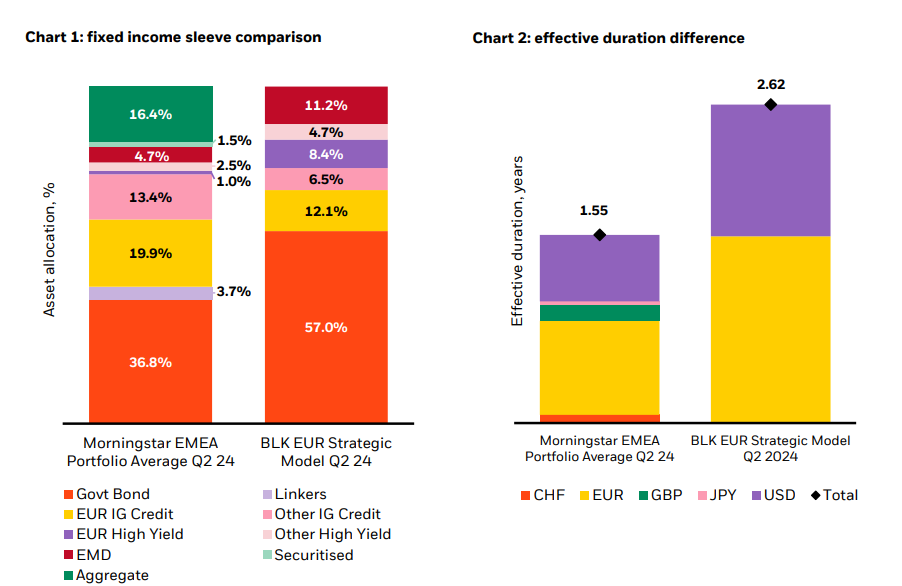

In [ ]:
from IPython.display import Image, display
display(Image(filename=img_path))

**Results analysis:**

As you can see, the extracted numbers are NOT accurate!!

How does this happen, especially considering the image extraction capabilities of Claude Sonnet 3.5?

I conducted the test without using the PDF feature, sending the image directly to Claude Sonnet 3.5 to compare the results:

In [ ]:
client_image = anthropic.Anthropic(api_key = CLAUDE_API_KEY)
def get_completion_image(messages):
    response = client_image.messages.create(
        model=MODEL_NAME,
        max_tokens=2048,
        temperature=0,
        messages=messages
    )
    return response.content[0].text

import io
import base64
from PIL import Image

image = Image.open(img_path)
image_data = io.BytesIO()
image.save(image_data, format='PNG', optimize=True, quality=75)
image_data.seek(0)
base64_encoded = base64.b64encode(image_data.getvalue()).decode('utf-8')

def append_message(content, question):
    content.append({"type": "text", "text": question})
    messages = [
      {
          "role": 'user',
          "content": content
      }
    ]
    return messages

question = """Extract all data included in Chart 1."""
content = [{"type": "image", "source": {"type": "base64", "media_type": "image/png", "data": base64_encoded},}]
messages = append_message(content, question)
print(get_completion_image(messages))

Here's all the data from Chart 1:

Morningstar EMEA Portfolio Average Q2 24:
- Aggregate: 16.4%
- EMD: 4.7%
- EUR High Yield: 2.5%
- Other High Yield: 1.0%
- Other IG Credit: 13.4%
- EUR IG Credit: 19.9%
- Linkers: 3.7%
- Govt Bond: 36.8%

BLK EUR Strategic Model Q2 24:
- Securitised: 11.2%
- Other High Yield: 4.7%
- EUR High Yield: 8.4%
- Other IG Credit: 6.5%
- EUR IG Credit: 12.1%
- Govt Bond: 57.0%


**Results** **analysis**:

It's almost perfect:

1:

1.   In the first Bar chart:

- Other High Yield: 2.5%
- EUR High Yield: 1.0%

instead of:

- EUR High Yield: 2.5%
- Other High Yield: 1.0%

Securitised was missed.


2.   In the second Bar chart:

-  The first value isn't about Securitised but EMD.
-  The other valeus are correct


**Next:**

Extracting data from image is better than using the pdf feature (for now), but it's still not that accurate.


## Simple Bar chart:

Now let's try to extract data from a simple bar chat:

In [ ]:
query = "Extract from page 8 all data included in Chart 2."
messages = build_message(query, pdf_data)
print("--------QUERY---------")
display(HTML(f"<p style='color:fuchsia;'>--------QUERY---------</p>"))
display(HTML(f"<p style='color:fuchsia;'>{query}</p>"))
print()
completion = get_completion(messages)
display(HTML(f"<p style='color:green;'>--------ANSWER---------</p>"))
print(completion.content[0].text)
print()
display(HTML(f"<p style='color:blue;'>--------TOKENS COUNT---------</p>"))
display(HTML(f"<p style='color:blue;'>{completion.usage}</p>"))
  # print(completion.usage)
print()
print("--------STOP REASON---------")
print(completion.stop_reason)
print("\n\n")

--------QUERY---------


Looking at Chart 2 "Effective duration difference" from page 8, here is the data:

Morningstar EMEA Portfolio Average Q2 24: 1.55 years
BLK EUR Strategic Model Q2 2024: 2.62 years

The chart shows effective duration in years broken down by currency (CHF, EUR, GBP, JPY, USD) with the total values listed above.




--------STOP REASON---------
end_turn





That's good. Accurate results!

# Ask about specific numbers

Let's ask about specific numbers inlcuded in the text (not in the charts) :

In [ ]:
query = "what are the current gold reserve levels for different countries around the world?"
messages = build_message(query, pdf_data)
print("--------QUERY---------")
display(HTML(f"<p style='color:fuchsia;'>--------QUERY---------</p>"))
display(HTML(f"<p style='color:fuchsia;'>{query}</p>"))
print()
completion = get_completion(messages)
display(HTML(f"<p style='color:green;'>--------ANSWER---------</p>"))
print(completion.content[0].text)
print()
display(HTML(f"<p style='color:blue;'>--------TOKENS COUNT---------</p>"))
display(HTML(f"<p style='color:blue;'>{completion.usage}</p>"))
  # print(completion.usage)
print()
print("--------STOP REASON---------")
print(completion.stop_reason)
print("\n\n")

--------QUERY---------


According to the document, there is significant variation in gold holdings as a percentage of overall reserves across different countries. Specifically, it mentions that some countries have gold holdings exceeding 70% of their reserves, while others like China and India hold significantly less, around 5-15% of their reserves. The document notes this disparity suggests there may be room for further gold allocation by some central banks. The document also indicates there was record central bank buying of gold in H1 2024, showing increased interest in gold reserves by central banks. However, it does not provide specific gold reserve levels for individual countries beyond these general percentage ranges.




--------STOP REASON---------
end_turn





Good results. Here is the reference:

**Source reference ==> Page 10:**

"""
Strong central bank demand for gold has also supported sentiment this year.
The latest data shows record central bank buying in H1 2024 – and our analysis suggests there may be room to run. As a percentage of overall reserves, we see some countries with gold holdings in excess of 70%, while others – including China and India – hold significantly less, at around the 5-15% range,5 pointing to space for further allocation."""

In [ ]:
query = "How has global M&A activity performed this year, and what growth rate does it reflect year-over-year?"
messages = build_message(query, pdf_data)
print("--------QUERY---------")
display(HTML(f"<p style='color:fuchsia;'>--------QUERY---------</p>"))
display(HTML(f"<p style='color:fuchsia;'>{query}</p>"))
print()
completion = get_completion(messages)
display(HTML(f"<p style='color:green;'>--------ANSWER---------</p>"))
print(completion.content[0].text)
print()
display(HTML(f"<p style='color:blue;'>--------TOKENS COUNT---------</p>"))
display(HTML(f"<p style='color:blue;'>{completion.usage}</p>"))
  # print(completion.usage)
print()
print("--------STOP REASON---------")
print(completion.stop_reason)
print("\n\n")

--------QUERY---------


According to the document, global M&A activity has reached $2.3T so far this year, representing a 26.8% increase year-over-year (YoY). This is mentioned in the context of discussing private equity opportunities and demonstrates significant growth in deal activity compared to the previous year.




--------STOP REASON---------
end_turn





Good results. Here is the reference:

**Source ==> Page 11:**

"""
As the landscape of technology, central bank rate trajectories and the lowcarbon transition continues to evolve, we believe private equity (PE) offers distinct advantages when integrated into existing portfolios. While global interest rates have started to fall, we see sticky inflation keeping rates elevated into 2025. This macro backdrop has shifted the focus of PE from leverage and
multiple expansion to driving value through operational improvements, revenue growth and margin enhancement. Global M&A activity has hit $2.3T so far this year, up 26.8% YoY, illustrating a wealth of opportunity in the space.
"""


# 👉 **Key Takeaways:**

- Easy to implement in the API.

- Maximum number of pages is 100, several financial reports are less than 100 pages.

- No need for chunking or embedding—just a single upload. However, the file needs to be re-uploaded each time.

- I used the prompt caching feature to reduce costs, but it only lasts for 5 minutes, which isn’t ideal...

- Chart data extraction isn't highly efficient yet, as it's still in beta.

- It accurately extracts information and answers various questions (unrelated to charts), providing insightful responses with numerical data.
